In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import concurrent.futures
import timeit
from typing import Callable, List, Optional, Tuple
from functools import partial
import copy
from itertools import groupby
import sys, os
from scipy.optimize import minimize
from scipy.spatial.distance import (
    cosine
)

from data_loader import load_grid_search_data, get_recon_pathname, get_recon_landscape
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter

# Fig. 10, Reconstructed landscapes using OSCAR preserve key features of the original landscapes

[[1.1963899265159905, 3.5013498517926864], [122.10647242191939, 66.89105318258646], [1.563804981870391, 4.59754459397948]]
[[0.03396575118, 0.03062864831], [0.05001929258, 0.04203118462], [0.04439624263, 0.04003329766]]
[[3.083008726, 3.061404465], [4.188213885, 4.105587744], [4.029826627, 4.001657739]]


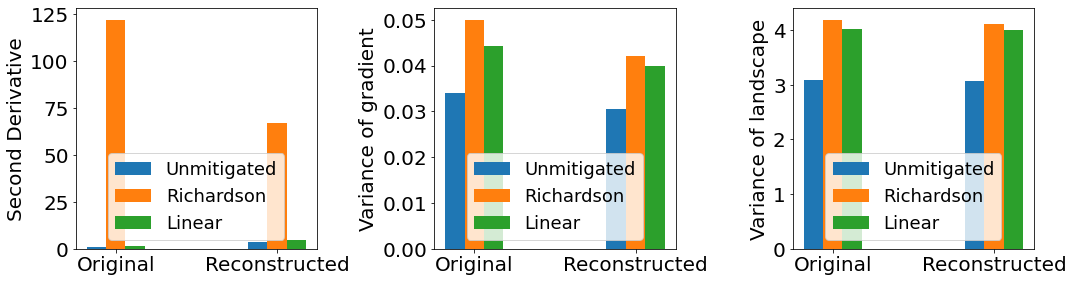

In [3]:
def vis_metric(ax, metric_name: str, labels: list, origin: list, recon: list):
    # bbox = dict(facecolor='yellow', pad=5, alpha=0.2)
    data = []
    for o, r in zip(origin, recon):
        data.append([o, r])

    print(data)

    xs = np.array(range(2))
    bar_width = 0.12
    ax.bar(xs, data[0], width=bar_width, label=labels[0])#, color="b")
    ax.bar(xs+bar_width, data[1], width=bar_width, label=labels[1])#, color="orange")
    ax.bar(xs+2*bar_width, data[2], width=bar_width, label=labels[2])#, color="orange")
    # axs[0].xticks(xs + bar_width/2, labels)
    ax.set_xticks(xs + bar_width)
    ax.set_xticklabels(["Original", "Reconstructed"])
    ax.set_ylabel(metric_name) #, bbox=bbox)
    ax.legend(loc='lower center')


params = {'legend.fontsize': 18,
          'figure.figsize': (15, 4),
         'axes.labelsize': 20, #'x-large',
         'axes.titlesize': 20, #'x-large',
         'xtick.labelsize': 20,
         'ytick.labelsize': 20,
         'pdf.fonttype': 42,
         'ps.fonttype': 42,
         }
plt.rcParams.update(params)

fig, axs = plt.subplots(nrows=1, ncols=3)
# plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places
# plt.legend()
# plt.show()

# vis_metric(
#     axs[0],
#     "Smoothness",
#     labels = ["Unmiti", "Richardson", "Linear"],
#     origin = [17.67519336,	21.55886429,	20.20787102],
#     recon = [16.89841502,	19.83555727, 19.31832727],
# )

vis_metric(
    axs[0],
    "Second Derivative",
    labels = ["Unmitigated", "Richardson", "Linear"],
    origin = [1.1963899265159905, 122.10647242191939, 1.563804981870391],
    recon = [3.5013498517926864, 66.89105318258646, 4.59754459397948],
)

vis_metric(
    axs[1],
    "Variance of gradient",
    labels = ["Unmitigated", "Richardson", "Linear"],
    origin = [0.03396575118,	0.05001929258,	0.04439624263],
    recon = [0.03062864831,	0.04203118462,	0.04003329766]
    
)

vis_metric(
    axs[2],
    "Variance of landscape",
    labels = ["Unmitigated", "Richardson", "Linear"],
    origin = [3.083008726,	4.188213885,	4.029826627],
    recon = [3.061404465,	4.105587744,	4.001657739] 
)

# axs[0].legend(loc=2)
# fig.align_ylabels(axs)
fig.tight_layout()
# axs[1].tight_layout()
# fig.subplots_adjust(wspace=0.3)
fig.savefig("paper_figs/miti_preserve.pdf", bbox_inches="tight", dpi=1000)

In [4]:
def _vis_landscapes(
        fig,
        axs: plt.Axes,
        landscapes, # list of np.ndarray
        labels, # list of labels of correlated landscapes
        full_range, # dict, 
        true_optima,
        params_paths, # list of list of parameters correlated to landscapes
        converged_soln_markers=None,
    ):

    assert len(landscapes) == len(labels)
    if isinstance(params_paths, list):
        assert len(landscapes) == len(params_paths)

    axs = axs.reshape(-1)

    # TODO Check ij and xy
    X, Y = np.meshgrid(full_range['beta'], full_range['gamma'], indexing="ij")

    # c = ax.pcolormesh(X, Y, Z, cmap='viridis', vmin=Z.min(), vmax=Z.max())
    for idx, landscape in enumerate(landscapes):
        im = axs[idx].pcolormesh(X, Y, landscape) #, cmap='viridis', vmin=origin.min(), vmax=origin.max())
        # axs[idx].set_xlabel('beta')
        # if idx == 0:
        #     axs[idx].set_ylabel('gamma')
        # # else:
        axs[idx].set_yticks([])
        axs[idx].set_xticks([])
        if isinstance(true_optima, list) or isinstance(true_optima, np.ndarray):
            axs[idx].plot(true_optima[1], true_optima[0], marker="o", color='red', markersize=7, label="true optima")

        params = params_paths[idx]
        if isinstance(params, list) or isinstance(params, np.ndarray):
            xs = [] # beta
            ys = [] # gamma
            for param in params:
                xs.append(param[1])
                ys.append(param[0])

            axs[idx].plot(xs, ys, linewidth=3, color='purple', label="opt. path")
            axs[idx].plot(xs[0], ys[0], marker="o", color='white', markersize=9, label="initial pt")

            if isinstance(converged_soln_markers, list):
                marker = converged_soln_markers[idx]
                if marker == '*':
                    markersize = 15
                elif marker == 'D':
                    markersize = 10
                
            else:
                marker = '*'
                markersize = 15

            axs[idx].plot(xs[-1], ys[-1], marker=marker,
                    color='red', markersize=markersize, label="converged pt")

            axs[idx].legend(loc='upper center')

    fig.colorbar(im, ax=[axs[i] for i in range(len(landscapes))], pad=0.05)


# Fig. 9, Richardson extrapolation and linear extrapolation mitigation methods


read grid search data from figs/grid_search/qaoa/maxcut/sv-depolar-0.001-0.02-p=1/maxcut-sv-depolar-0.001-0.02-n=16-p=1-seed=0-50-100-zne-RichardsonFactory.npz


read grid search data from figs/grid_search/qaoa/maxcut/sv-depolar-0.001-0.02-p=1/maxcut-sv-depolar-0.001-0.02-n=16-p=1-seed=0-50-100-zne-LinearFactory.npz

recon landscape read from figs/grid_search_recon/qaoa/maxcut/sv-depolar-0.001-0.02-p=1/recon-cs_seed=16-sf=0.050-maxcut-sv-depolar-0.001-0.02-n=16-p=1-seed=0-50-100-zne-RichardsonFactory.npz
recon landscape read from figs/grid_search_recon/qaoa/maxcut/sv-depolar-0.001-0.02-p=1/recon-cs_seed=16-sf=0.050-maxcut-sv-depolar-0.001-0.02-n=16-p=1-seed=0-50-100-zne-LinearFactory.npz
save to  paper_figs/comp_richardson_and_linear.pdf


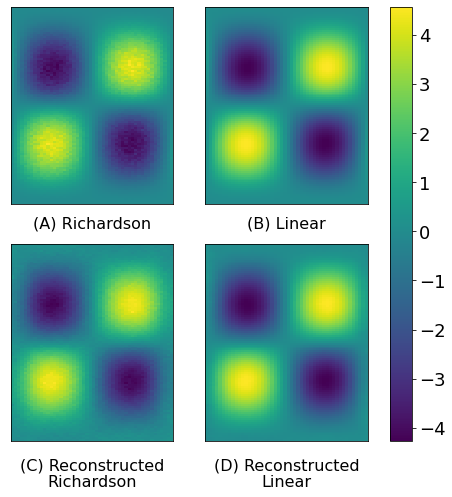

In [5]:
def vis_comp_Richardson_and_Linear():
    # read grid search data from figs/grid_search/maxcut/sv-depolar-0.001-0.02-p=1/maxcut-sv-depolar-0.001-0.02-n=16-p=1-seed=0-50-100-zne-RichardsonFactory.npz
    # read grid search data from figs/grid_search/maxcut/sv-depolar-0.001-0.02-p=1/maxcut-sv-depolar-0.001-0.02-n=16-p=1-seed=0-50-100-zne-LinearFactory.npz
    method = 'sv'
    problem = 'maxcut'
    miti_method1 = 'zne-RichardsonFactory'
    miti_method2 = 'zne-LinearFactory'

    # noise-3
    p1 = 0.001
    p2 = 0.02
    n_qubits = 16

    noise = f'depolar-{p1}-{p2}'

    # n_qubits = 16
    cs_seed = n_qubits
    p = 1
    sf = 0.05
    seed = 0
    if p == 2:
        bs = 12
        gs = 15
    elif p == 1:
        bs = 50
        gs = 100
    else:
        raise ValueError("Invalid depth of QAOA")

    ansatz = 'qaoa'
    ideal_data1, ideal_data1_fname, _ = load_grid_search_data(
        n_qubits=n_qubits, p=p, ansatz=ansatz, problem=problem, method=method,
        noise=noise, beta_step=bs, gamma_step=gs, seed=seed, miti_method=miti_method1
    )
    ideal_data2, ideal_data2_fname, _ = load_grid_search_data(
        n_qubits=n_qubits, p=p, ansatz=ansatz, problem=problem, method=method,
        noise=noise, beta_step=bs, gamma_step=gs, seed=seed, miti_method=miti_method2
    )

    full_range = ideal_data1['full_range']

    recon_path1, _, _ = get_recon_pathname(ansatz, p, problem, method, noise, cs_seed, sf, ideal_data1_fname)
    recon1 = get_recon_landscape(ansatz, p, ideal_data1['data'], sf, False, recon_path1, cs_seed)
    
    recon_path2, _, _ = get_recon_pathname(ansatz, p, problem, method, noise, cs_seed, sf, ideal_data2_fname)
    recon2 = get_recon_landscape(ansatz, p, ideal_data2['data'], sf, False, recon_path2, cs_seed)

    params = {'legend.fontsize': 18,
          'figure.figsize': (8, 8),
         'axes.labelsize': 16, #'x-large',
         'axes.titlesize': 16, #'x-large',
         'xtick.labelsize': 18,
         'ytick.labelsize': 18,
         'pdf.fonttype': 42,
         'ps.fonttype': 42,
         }
    plt.rcParams.update(params)

    fig, axs = plt.subplots(nrows=2, ncols=2)
    axs = axs.reshape(-1)
    labels=["(A) Richardson", "(B) Linear", "(C) Reconstructed\nRichardson", "(D) Reconstructed\nLinear"]
    save_path="paper_figs/comp_richardson_and_linear.pdf"

    _vis_landscapes(
        fig,
        axs,
        landscapes=[ideal_data1['data'], ideal_data2['data'], recon1, recon2],
        labels=labels,
        full_range=full_range,
        true_optima=None,
        params_paths=[None] * len(labels),
        converged_soln_markers=[None] * len(labels)
    )

    for idx in [0,1]:
        axs[idx].set_title(labels[idx], y=-0.15)
    
    # for idx in [0,2]:
    #     axs[idx].set_ylabel(r"$\gamma$")

    # for idx in [0,1,2,3]:
    #     axs[idx].set_xlabel(r"$\beta$")
        
    for idx in [2,3]:
        axs[idx].set_title(labels[idx], y=-0.26)
    # axs[1].set_title(labels[1], y=-0.3)
    # if save_path != None:
    print("save to ", save_path)
    fig.savefig(save_path, bbox_inches='tight', dpi=1000)
    plt.show()
    plt.close('all')
vis_comp_Richardson_and_Linear()